In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="./font/simsun.ttc", size=14)

import seaborn as sns
sns.set(font='./font/simsun.ttc')

# Parameters for demand and supply curves
params = {
    'a': 200,
    'e': 0.9,
    'c': 5,
    'f': 1.0,
    'delta': 0.3  # Change in demand for treatment group
}

# Constant elasticity demand function
def q_demand_control(p, a, e):
    return a * p ** (- e)

# Demand function for treatment group
def q_demand_treat(p, a, e, delta):
    return (1+delta) * a * p ** (- e)

def Q_demand_aggregate(p, a, e, delta):
    return  q_demand_control(p, a, e) + q_demand_treat(p, a, e, delta)

# Constant elasticity supply function
def Q_supply(p, c, f):
    return c * p ** f

# Counterfactual demand functions
def q_demand_all_treated(p, a, e, delta):
    return 2*q_demand_treat(p, a, e, delta)

def q_demand_all_not_treated(p, a, e):
    return 2*q_demand_control(p, a, e)

# Define the system of nonlinear equations
def equilibrium_experiment(a, e, c, f, delta):
    from scipy.optimize import fsolve
    def aggregate_demand_minus_supply(p):
        return Q_demand_aggregate(p, a, e, delta) - Q_supply(p, c, f)

    eq_p = fsolve(aggregate_demand_minus_supply, 1)[0]
    eq_q = Q_demand_aggregate(eq_p, a, e, delta)
    eq_q_control = q_demand_control(eq_p, a, e)
    eq_q_treat = q_demand_treat(eq_p, a, e, delta)
    return eq_p, eq_q, eq_q_control, eq_q_treat

def equilibrium_all_treated(a, e, c, f, delta):
    from scipy.optimize import fsolve
    def aggregate_demand_minus_supply(p):
        return q_demand_all_treated(p, a, e,delta) - Q_supply(p, c, f)

    eq_p = fsolve(aggregate_demand_minus_supply, 1)[0]
    eq_q = q_demand_all_treated(eq_p, a, e,delta)
    return eq_p, eq_q

def equilibrium_all_not_treated(a, e, c, f, delta):
    from scipy.optimize import fsolve
    def aggregate_demand_minus_supply(p):
        return q_demand_all_not_treated(p, a, e) - Q_supply(p, c, f)

    eq_p = fsolve(aggregate_demand_minus_supply, 1)[0]
    eq_q = q_demand_all_not_treated(eq_p, a, e)
    return eq_p, eq_q

# Calculate equilibrium price and quantity in experiment
eq_p, eq_q, eq_q_control, eq_q_treat  = equilibrium_experiment(params['a'], params['e'], params['c'], params['f'], params['delta'])

# Find equilibrium points for counterfactual situations

eq_p_all_treated, eq_q_all_treated = equilibrium_all_treated(params['a'], params['e'], params['c'], params['f'], params['delta'])
eq_p_all_not_treated, eq_q_all_not_treated = equilibrium_all_not_treated(params['a'], params['e'], params['c'], params['f'], 0)

# Compute the true global treatment effect
GTE_true = eq_q_all_treated - eq_q_all_not_treated
GTE_hat = (eq_q_treat - eq_q_control)*2
bias_quantity = (GTE_hat - GTE_true)/GTE_true

GTE_true = eq_q_all_treated*eq_p_all_treated - eq_q_all_not_treated*eq_p_all_not_treated
GTE_hat = (eq_q_treat - eq_q_control)*eq_p*2
bias_revenue = (GTE_hat - GTE_true)/GTE_true

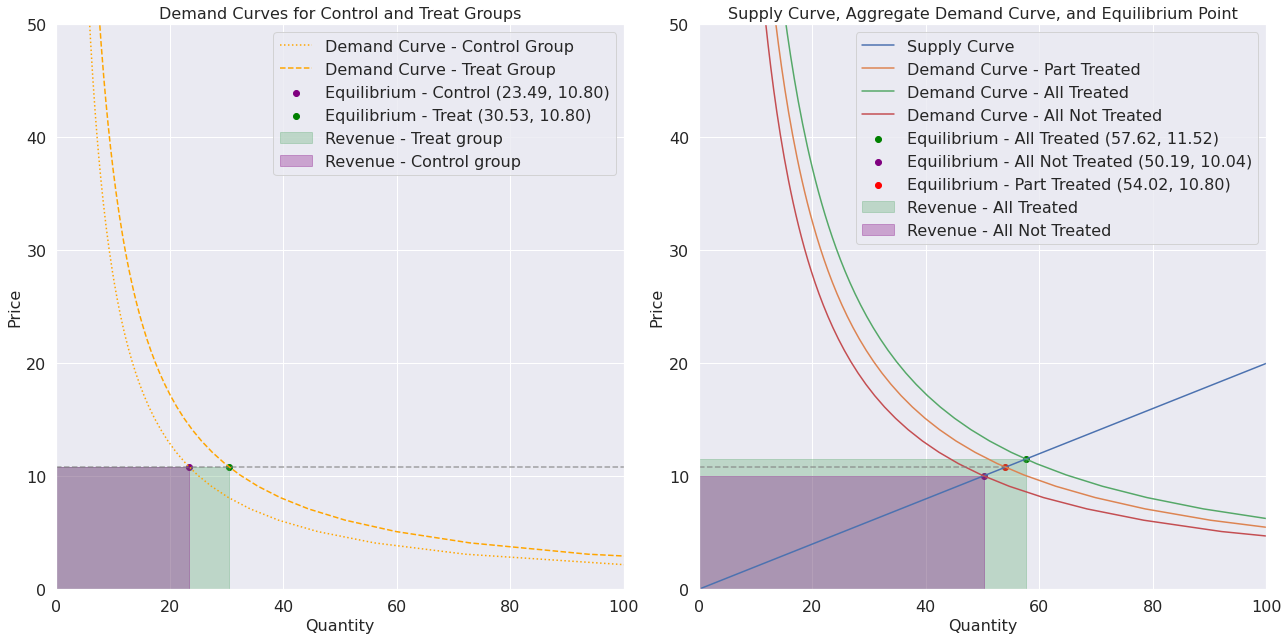

In [3]:
p = np.linspace(0.1, 400, 400)
# Create a 1x2 subplot
FontSize = 16

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))


# Left plot: Control and Treatment Groups' Demand Curves
ax1.plot(q_demand_control(p, params['a'], params['e']), p, color='orange',label='Demand Curve - Control Group', linestyle='dotted')
ax1.plot(q_demand_treat(p, params['a'], params['e'], params['delta']), p, color='orange', label='Demand Curve - Treat Group', linestyle='dashed')

# Add horizontal dashed line to indicate equilibrium
ax1.hlines(eq_p, 0, 200, colors='gray', linestyles='dashed', alpha=0.7)

# Add equilibrium points to the left plot
ax1.scatter(eq_q_control, eq_p, color='purple', label=f'Equilibrium - Control ({eq_q_control:.2f}, {eq_p:.2f})')
ax1.scatter(eq_q_treat, eq_p, color='green', label=f'Equilibrium - Treat ({eq_q_treat:.2f}, {eq_p:.2f})')

ax1.set_xlabel('Quantity', fontsize= FontSize)
ax1.set_ylabel('Price', fontsize= FontSize)
ax1.set_xlim((0, 100))
ax1.set_ylim((0, 50))
ax1.set_title('Demand Curves for Control and Treat Groups', fontsize= FontSize)
ax1.tick_params(axis='both', labelsize=FontSize)


# Add rectangular patches for the areas between the origin and the equilibrium points
rect_treated = patches.Rectangle((0, 0), eq_q_treat,     eq_p, linewidth=1, edgecolor='g', facecolor='g', alpha=0.3, label='Revenue - Treat group')
rect_control = patches.Rectangle((0, 0), eq_q_control,   eq_p, linewidth=1, edgecolor='purple', facecolor='purple', alpha=0.3, label='Revenue - Control group')
ax1.add_patch(rect_treated)
ax1.add_patch(rect_control)
ax1.legend(fontsize= FontSize)

# Right plot: Supply Curve, Aggregate Demand Curve, and Equilibrium Point
ax2.plot(Q_supply(p, params['c'], params['f']), p, label='Supply Curve')
ax2.plot(Q_demand_aggregate(p, params['a'], params['e'], params['delta']), p, label='Demand Curve - Part Treated')
ax2.plot(q_demand_all_treated(p, params['a'], params['e'], params['delta']), p, label='Demand Curve - All Treated')
ax2.plot(q_demand_all_not_treated(p, params['a'], params['e']), p, label='Demand Curve - All Not Treated')

# Add horizontal dashed line to indicate equilibrium
ax2.hlines(eq_p, 0, eq_q, colors='gray', linestyles='dashed', alpha=0.7)

ax2.scatter(eq_q_all_treated, eq_p_all_treated, color='green', label=f'Equilibrium - All Treated ({eq_q_all_treated:.2f}, {eq_p_all_treated:.2f})')
ax2.scatter(eq_q_all_not_treated, eq_p_all_not_treated, color='purple', label=f'Equilibrium - All Not Treated ({eq_q_all_not_treated:.2f}, {eq_p_all_not_treated:.2f})')
ax2.scatter(eq_q, eq_p, color='red', label=f'Equilibrium - Part Treated ({eq_q:.2f}, {eq_p:.2f})')
ax2.set_xlabel('Quantity', fontsize= FontSize)
ax2.set_ylabel('Price', fontsize= FontSize)
ax2.set_xlim((0, 100))
ax2.set_ylim((0, 50))
ax2.set_title('Supply Curve, Aggregate Demand Curve, and Equilibrium Point', fontsize= FontSize)
ax2.tick_params(axis='both', labelsize=FontSize)

# Add rectangular patches for the areas between the origin and the equilibrium points
rect_all_treated = patches.Rectangle((0, 0), eq_q_all_treated, eq_p_all_treated, linewidth=1, edgecolor='g', facecolor='g', alpha=0.3, label='Revenue - All Treated')
rect_all_not_treated = patches.Rectangle((0, 0), eq_q_all_not_treated, eq_p_all_not_treated, linewidth=1, edgecolor='purple', facecolor='purple', alpha=0.3, label='Revenue - All Not Treated')
ax2.add_patch(rect_all_treated)
ax2.add_patch(rect_all_not_treated)
ax2.legend(fontsize= FontSize)
plt.tight_layout()
plt.savefig('./pic/exp.png')
plt.show()


To visualize how the change of each parameter in params affects the biases bias_quantity and bias_revenue, we can create a function that calculates these biases for different parameter values. Then, we can plot the results for each parameter.

Here's a function to compute the biases:

In [4]:
def compute_biases(a, e, c, f, delta):
    eq_p, eq_q, eq_q_control, eq_q_treat = equilibrium_experiment(a, e, c, f, delta)
    eq_p_all_treated, eq_q_all_treated = equilibrium_all_treated(a, e, c, f, delta)
    eq_p_all_not_treated, eq_q_all_not_treated = equilibrium_all_not_treated(a, e, c, f, 0)
    
    GTE_true_quantity = eq_q_all_treated - eq_q_all_not_treated
    GTE_hat_quantity = (eq_q_treat - eq_q_control) * 2
    bias_quantity = (GTE_hat_quantity - GTE_true_quantity) / GTE_true_quantity
    
    GTE_true_revenue = eq_q_all_treated * eq_p_all_treated - eq_q_all_not_treated * eq_p_all_not_treated
    GTE_hat_revenue = (eq_q_treat - eq_q_control) * eq_p * 2
    bias_revenue = (GTE_hat_revenue - GTE_true_revenue) / GTE_true_revenue
    
    return bias_quantity, bias_revenue

Now we can create a plot for each parameter in params:

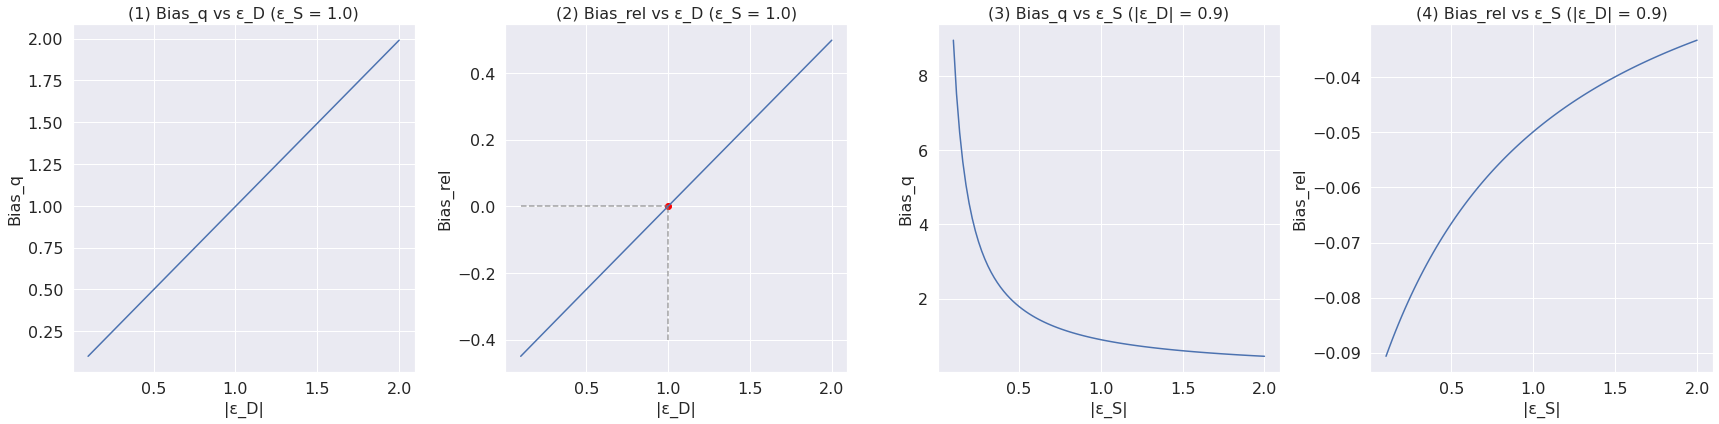

In [5]:
param_values = np.linspace(0.1, 2, 100)
FontSize = 16
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for idx, param_name in enumerate(['e','f']):
    bias_quantity_list = []
    bias_revenue_list = []
    
    for param_value in param_values:
        temp_params = params.copy()
        temp_params[param_name] = param_value
        bias_quantity, bias_revenue = compute_biases(**temp_params)
        bias_quantity_list.append(bias_quantity)
        bias_revenue_list.append(bias_revenue)
    
    if param_name == 'e':
        param_name = 'ε_D' + ' (ε_S = 1.0)'
    elif param_name == 'f':
        param_name = 'ε_S' + ' (|ε_D| = 0.9)'
        
    ax1 = axes[idx*2 + 0]
    ax1.plot(param_values, bias_quantity_list)
    ax1.set_title(f"({idx*2 + 1}) Bias_q vs {param_name}", fontsize= FontSize)
    ax1.set_xlabel('|'+param_name[0:3]+'|', fontsize= FontSize)
    ax1.set_ylabel("Bias_q", fontsize= FontSize)
    ax1.tick_params(axis='both', labelsize=FontSize)

    
    ax2 = axes[idx*2 + 1]
    ax2.plot(param_values, bias_revenue_list)

    ax2.set_title(f"({idx*2 + 2}) Bias_rel vs {param_name}", fontsize= FontSize)
    ax2.set_xlabel('|'+param_name[0:3]+'|', fontsize= FontSize)
    ax2.set_ylabel("Bias_rel", fontsize= FontSize)
    ax2.tick_params(axis='both', labelsize=FontSize)

    
axes[1].hlines(0, 0.1, 1, colors='gray', linestyles='dashed', alpha=0.7)
axes[1].vlines(1, -0.4, 0, colors='gray', linestyles='dashed', alpha=0.7)
axes[1].scatter(1, 0, color='red')
plt.tight_layout()
plt.savefig('./pic/Bias_rel1.png')
plt.show()

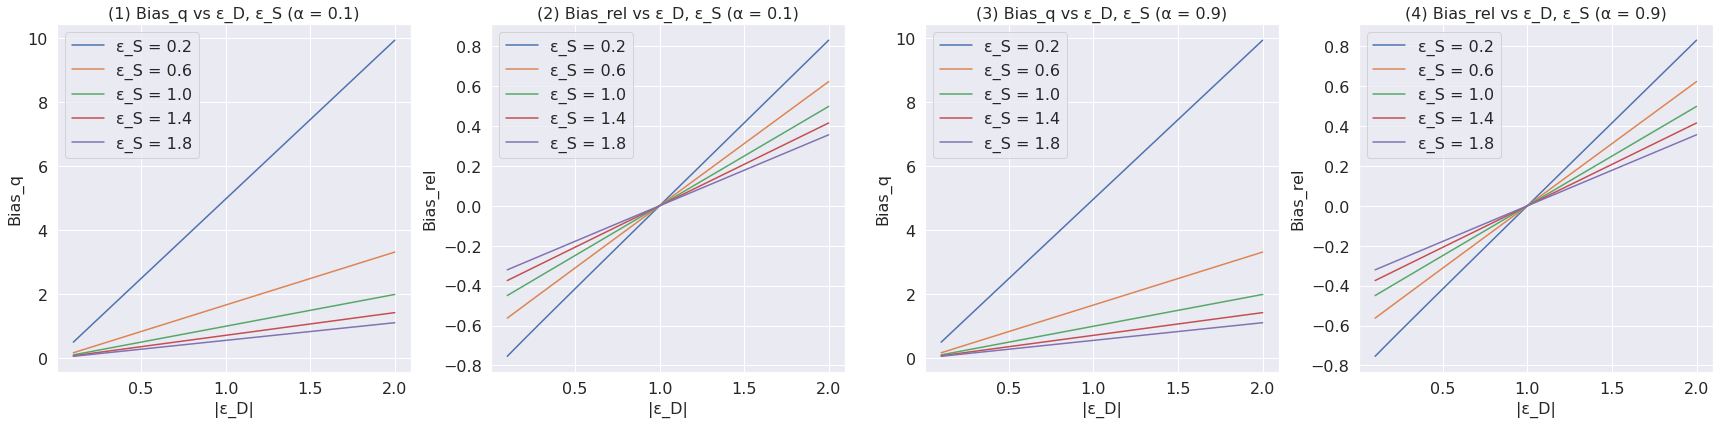

In [6]:
e_values = np.linspace(0.1, 2, 100)
f_values = [0.2, 0.6, 1.0, 1.4, 1.8]
FontSize = 16

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for f_value in f_values:
    bias_quantity_list = []
    bias_revenue_list = []
    temp_params = {
    'a': 200,
    'e': 0.9,
    'c': 5,
    'f': 1.0,
    'delta': 0.1}

    for e_value in e_values:
        temp_params = params.copy()
        temp_params['e'] = e_value
        temp_params['f'] = f_value
        bias_quantity, bias_revenue = compute_biases(**temp_params)
        bias_quantity_list.append(bias_quantity)
        bias_revenue_list.append(bias_revenue)

    ax1 = axes[0]
    ax1.plot(e_values, bias_quantity_list, label=f"ε_S = {f_value}")
    ax1.set_title(f"(1) Bias_q vs ε_D, ε_S (α = 0.1)",fontsize= FontSize)
    ax1.set_xlabel("|ε_D|",fontsize= FontSize)
    ax1.set_ylabel("Bias_q",fontsize= FontSize)
    ax1.legend(fontsize= FontSize)
    ax1.tick_params(axis='both', labelsize=FontSize)


    ax2 = axes[1]
    ax2.plot(e_values, bias_revenue_list, label=f"ε_S = {f_value}")
    ax2.set_title(f"(2) Bias_rel vs ε_D, ε_S (α = 0.1)",fontsize= FontSize)
    ax2.set_xlabel("|ε_D|",fontsize= FontSize)
    ax2.set_ylabel("Bias_rel",fontsize= FontSize)
    ax2.legend(fontsize= FontSize)
    ax2.tick_params(axis='both', labelsize=FontSize)

    

    
for f_value in f_values:
    bias_quantity_list = []
    bias_revenue_list = []
    temp_params = {
    'a': 200,
    'e': 0.9,
    'c': 5,
    'f': 1.0,
    'delta': 0.9}

    for e_value in e_values:
        temp_params = params.copy()
        temp_params['e'] = e_value
        temp_params['f'] = f_value
        bias_quantity, bias_revenue = compute_biases(**temp_params)
        bias_quantity_list.append(bias_quantity)
        bias_revenue_list.append(bias_revenue)

    ax3 = axes[2]
    ax3.plot(e_values, bias_quantity_list, label=f"ε_S = {f_value}")
    ax3.set_title("(3) Bias_q vs ε_D, ε_S (α = 0.9)",fontsize= FontSize)
    ax3.set_xlabel("|ε_D|",fontsize= FontSize)
    ax3.set_ylabel("Bias_q",fontsize= FontSize)
    ax3.legend(fontsize= FontSize)
    ax3.tick_params(axis='both', labelsize=FontSize)

    ax4 = axes[3]
    ax4.plot(e_values, bias_revenue_list, label=f"ε_S = {f_value}")
    ax4.set_title("(4) Bias_rel vs ε_D, ε_S (α = 0.9)",fontsize= FontSize)
    ax4.set_xlabel("|ε_D|",fontsize= FontSize)
    ax4.set_ylabel("Bias_rel",fontsize= FontSize)
    ax4.legend(fontsize= FontSize)
    ax4.tick_params(axis='both', labelsize=FontSize)

    
plt.tight_layout()
plt.savefig('./pic/Bias_rel2.png')
plt.show()